**Lindbald Master Equation and Hamiltonian**

---

$$ \dot\rho=-i[H_{1},\rho]+\gamma_{1D}[2\sigma_{1}\rho\sigma_{1}^{\dagger}-\sigma_{1}^{\dagger}\sigma_{1}\rho-\rho\sigma_{1}^{\dagger}\sigma_{1}] $$

$$ H_{1}=[\omega_{0}+A_{j}(t)]\sigma_{1}^{\dagger}\sigma_{1}-\frac{i\Omega_{R}}{2}(e^{-i\varepsilon t}\sigma_{1}^{\dagger}-H.c) $$

**Hamiltonian with Detuning**



---
$$ U(t)=e^{i\epsilon t\sigma_{1}^{\dagger}\sigma_{1}} $$

$$ H_{1}^{'}=U^{\dagger}H_{1}U - iU^{\dagger}\frac{\partial U}{\partial t} $$

$$ iU^{\dagger}\frac{\partial U}{\partial t} = i(-i\epsilon)\sigma_{1}^{\dagger}\sigma_{1} = -\epsilon\sigma_{1}^{\dagger}\sigma_{1} $$

$$ U^{\dagger}(e^{-i\epsilon t}\sigma_{1}^{\dagger})U = e^{-i\epsilon t} \cdotp e^{i\epsilon t} \sigma_{1}^{\dagger} = \sigma_{1}^{\dagger}$$

$$ \delta = \omega_{0} - \epsilon $$

$$ H^{'}_{1}(t) = [\delta + A_{j}(t)]\sigma_{1}^{\dagger}\sigma_{1} - \frac{i\Omega_{R}}{2}(\sigma_{1}^{\dagger} - \sigma_{1}) $$


**Imports**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.linalg import expm

%matplotlib inline

**Parameters**

In [28]:
gamma_1D = 1.0   # Decay rate
D = 0.5          # Detuning d = (omega_0 - epsilon)
Omega = 5        # Modulation frequency
Omega_R = 0.05   # Rabi frequency
A = 0.025        # Modulation amplitude (0.025)

psi0 = np.array([1, 0], dtype=complex)  # Initial ground state, outer product
rho0 = np.outer(psi0, psi0.conj())
rho0_vec = rho0.flatten()

t_final = 6 / gamma_1D
times = np.linspace(0, t_final, 1000)

omega_range = np.linspace(-50, 50, 2000)
delay_times = np.linspace(0, 10, 500)

In [30]:
def pauli_matrices():
    sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)
    sigma_y = np.array([[0, -1j], [1j, 0]], dtype=complex)
    sigma_z = np.array([[1, 0], [0, -1]], dtype=complex)

    # Lowering operator (sigma_-)
    sigma = np.array([[0, 1], [0, 0]], dtype=complex)

    # Raising operator (sigma_+)
    sigma_dag = np.array([[0, 0], [1, 0]], dtype=complex)

    # Number operator
    n = sigma_dag @ sigma

    # Identity
    I = np.eye(2, dtype=complex)

    return sigma_x, sigma_y, sigma_z, sigma, sigma_dag, n, I

sigma_x, sigma_y, sigma_z, sigma, sigma_dag, n, I = pauli_matrices()


def A_modulation(t):
    return A * np.cos(Omega * t)


def hamiltonian(t):
    A_t = A_modulation(t)
    return (D + A_t) * n - ((1j * Omega_R) / 2) * (sigma_dag - sigma)


def commutator(A, B):
    return (A @ B) - (B @ A)


def lindblad_term(rho, s):
    s_dag = s.conj().T
    return 2 * s @ rho @ s_dag - s_dag @ s @ rho - rho @ s_dag @ s


def lindblad_master_equation(t, rho_vec):
    rho = rho_vec.reshape((2, 2))
    H = hamiltonian(t)  # Hamiltonian at time (t)
    drho_dt = (-1j * commutator(H, rho)) + (gamma_1D * lindblad_term(rho, sigma))
    return drho_dt.flatten()


def calculate_P(s):
    term1 = (s + 2 * gamma_1D)
    term2_inner = (s + gamma_1D)**2 + (Omega - D)**2
    term3 = Omega_R**2 * (s + gamma_1D)

    P_s = (term1 * term2_inner) + term3
    return P_s


def calculate_B1(s, omega_R, gamma_1D, D, Omega):
    term_1 = -1j * (omega_R / 2) * np.exp(-1j * Omega * 0)
    term_2 = s + gamma_1D * 2
    term_3 = s + gamma_1D - 1j * (Omega - D)
    P_s = calculate_P(s)

    result = term_1 * term_2 * term_3 / P_s
    return result


def calculate_B2(s, omega_R, gamma_1D, D, Omega):
    term_1 = 1j * (omega_R / 2) * np.exp(-1j * Omega * 0)
    term_2 = s + gamma_1D * 2
    term_3 = s + gamma_1D + 1j * (Omega - D)
    P_s = calculate_P(s)

    result = term_1 * term_2 * term_3 / P_s
    return result


def calculate_B3(s, gamma_1D, D, Omega):
    term_1 = -(s + gamma_1D * 2)
    term_2 = (s + gamma_1D)**2 + (Omega - D)**2
    P_s = calculate_P(s)

    result = term_1 * term_2 / P_s
    return result


# Inverse Laplace transform using numerical integration
def inverse_laplace_transform(B_func, times, omega_range, *args):
    """
    Compute inverse Laplace transform numerically using the inverse Fourier transform.
    f(t) = (1/2π) ∫ F(iω) e^(iωt) dω
    """
    s_values = 1j * omega_range
    B_values = np.array([B_func(s, *args) for s in s_values])

    # Compute inverse transform for each time point
    result = np.zeros(len(times), dtype=complex)
    dw = omega_range[1] - omega_range[0]

    for i, t in enumerate(times):
        integrand = B_values * np.exp(1j * omega_range * t)
        result[i] = np.trapz(integrand, dx=dw) / (2 * np.pi)

    return result


def calculate_correlation_function(s, omega_R, gamma_1D, D, Omega):
    """
    Laplace transform of <sigma_+(t)sigma_-(t+δt)> correlation function
    From the paper equation:
    L[e^(ikδt)<σ+(t)σ-(t+δt)>] = (R²/2) / (1 + D² + R²/2) * [P(s) - (ωR²/2)(s + γ/2)] / [sP(s)]

    Where:
    - D = (Ω - epsilon) is normalized detuning
    - R = ωR*r is normalized Rabi frequency → Omega_R in our notation
    - γ/2 = gamma_1D in our notation
    """
    # Normalized parameters (assuming r=1 for simplicity)
    D_normalized = D
    R_normalized = omega_R     # Paper's R = ωR

    # Prefactor
    prefactor = (0.25 * R_normalized**2) / (1 + D_normalized**2 + 0.5 * R_normalized**2)

    # P(s)
    P_s = calculate_P(s)

    # Numerator: P(s) - (ωR²/2)(s + γ/2)
    numerator = P_s - 0.5 * omega_R**2 * (s + gamma_1D)

    # Full expression
    result = prefactor * numerator / (s * P_s)

    return result


def optical_bloch_ode(t, c, gamma_1D, Omega, Omega_R, b_n):
    # Let 1/Tau = Gamma_1D, Tau = 1/Gamma_1D, k = 0, phi = 0

    B = np.array([
        [-(gamma_1D + 1j * Omega),    0,                          0.5j * Omega_R],
        [0,                           -(gamma_1D - 1j * Omega),   -0.5j * Omega_R],
        [1j * Omega_R,                -1j * Omega_R,              -2 * gamma_1D]
    ], dtype=complex)

    return B @ c + b_n


def solve_c1(c1_initial, times, gamma_1D, Omega, Omega_R):
    # b_1 = -2/τ
    b1 = np.array([0, 0, -2*gamma_1D], dtype=complex)

    def ode_func(t, c):
        return optical_bloch_ode(t, c, gamma_1D, Omega, Omega_R, b1)

    solution = solve_ivp(
        ode_func,
        t_span=(times[0], times[-1]),
        y0=c1_initial,
        t_eval=times,
        method='DOP853',
        rtol=1e-8,
        atol=1e-10
    )

    return solution


def solve_c2(c2_initial, times, gamma_1D, Omega, Omega_R, sigma_plus_at_t):
    # b_2 = -2/τ · ⟨σ₊(t)⟩ in third position
    b2 = np.array([0, 0, -2*gamma_1D*sigma_plus_at_t], dtype=complex)

    # ODE wrapper
    def ode_func(t, c):
        return optical_bloch_ode(t, c, gamma_1D, Omega, Omega_R, b2)

    solution = solve_ivp(
        ode_func,
        t_span=(times[0], times[-1]),
        y0=c2_initial,
        t_eval=times,
        method='DOP853',
        rtol=1e-8,
        atol=1e-10
    )

    return solution


def get_initial_c1_from_state(psi):
    # Density matrix
    rho = np.outer(psi, psi.conj())

    # Pauli operators
    sigma_minus = np.array([[0, 1], [0, 0]], dtype=complex)
    sigma_plus = np.array([[0, 0], [1, 0]], dtype=complex)
    sigma_z = np.array([[1, 0], [0, -1]], dtype=complex)

    c1 = np.array([
        np.trace(rho @ sigma_minus),
        np.trace(rho @ sigma_plus),
        np.trace(rho @ sigma_z)
    ], dtype=complex)

    return c1


def get_initial_c2_from_c1_steady_state(c1_steady_state):
    sigma_plus = c1_steady_state[1]
    sigma_minus = c1_steady_state[0]

    # ⟨σ₊σ₋⟩ = ⟨n⟩
    n = sigma_plus * sigma_minus  # Approximation for steady state

    c2_initial = np.array([
        n,           # ⟨σ₊(t)σ₋(t)⟩
        0,           # ⟨σ₊(t)σ₊(t)⟩ = 0
        sigma_plus   # ⟨σ₊(t)σ_z(t)⟩ ≈ ⟨σ₊(t)⟩
    ], dtype=complex)

    return c2_initial

#############################################
########## Main Plots   #####################
#############################################


def plot_c1_solution(solution, times):
    """Plot c₁ solution components."""
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # ⟨σ₋(t)⟩
    axes[0].plot(times, solution.y[0].real, 'b-', linewidth=2, label='Re⟨σ₋⟩')
    axes[0].plot(times, solution.y[0].imag, 'r--', linewidth=2, label='Im⟨σ₋⟩')
    axes[0].set_xlabel('Time (1/γ₁D)', fontsize=12)
    axes[0].set_ylabel('⟨σ₋(t)⟩', fontsize=12)
    axes[0].set_title('Single-Time: ⟨σ₋(t)⟩', fontsize=13, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # ⟨σ₊(t)⟩
    axes[1].plot(times, solution.y[1].real, 'b-', linewidth=2, label='Re⟨σ₊⟩')
    axes[1].plot(times, solution.y[1].imag, 'r--', linewidth=2, label='Im⟨σ₊⟩')
    axes[1].set_xlabel('Time (1/γ₁D)', fontsize=12)
    axes[1].set_ylabel('⟨σ₊(t)⟩', fontsize=12)
    axes[1].set_title('Single-Time: ⟨σ₊(t)⟩', fontsize=13, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # ⟨σ_z(t)⟩
    axes[2].plot(times, solution.y[2].real, 'g-', linewidth=2)
    axes[2].axhline(y=-1, color='k', linestyle=':', alpha=0.5, label='Ground')
    axes[2].axhline(y=1, color='k', linestyle=':', alpha=0.5, label='Excited')
    axes[2].set_xlabel('Time (1/γ₁D)', fontsize=12)
    axes[2].set_ylabel('⟨σ_z(t)⟩', fontsize=12)
    axes[2].set_title('Single-Time: ⟨σ_z(t)⟩', fontsize=13, fontweight='bold')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    return fig


def plot_c2_solution(solution, times):
    """Plot c₂ solution components."""
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # ⟨σ₊(t)σ₋(t')⟩
    axes[0].plot(times, solution.y[0].real, 'b-', linewidth=2, label='Real')
    axes[0].plot(times, solution.y[0].imag, 'r--', linewidth=2, label='Imaginary')
    axes[0].set_xlabel('Time Delay t\' (1/γ₁D)', fontsize=12)
    axes[0].set_ylabel('⟨σ₊(t)σ₋(t\')⟩', fontsize=12)
    axes[0].set_title('Two-Time: ⟨σ₊(t)σ₋(t\')⟩', fontsize=13, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # ⟨σ₊(t)σ₊(t')⟩
    axes[1].plot(times, solution.y[1].real, 'b-', linewidth=2, label='Real')
    axes[1].plot(times, solution.y[1].imag, 'r--', linewidth=2, label='Imaginary')
    axes[1].set_xlabel('Time Delay t\' (1/γ₁D)', fontsize=12)
    axes[1].set_ylabel('⟨σ₊(t)σ₊(t\')⟩', fontsize=12)
    axes[1].set_title('Two-Time: ⟨σ₊(t)σ₊(t\')⟩', fontsize=13, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # ⟨σ₊(t)σ_z(t')⟩ - Log scale
    axes[2].semilogy(times, np.abs(solution.y[2]), 'purple', linewidth=2)
    axes[2].set_xlabel('Time Delay t\' (1/γ₁D)', fontsize=12)
    axes[2].set_ylabel('|⟨σ₊(t)σ_z(t\')⟩|', fontsize=12)
    axes[2].set_title('Two-Time: |⟨σ₊(t)σ_z(t\')⟩|', fontsize=13, fontweight='bold')
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    return fig

def plot_c1_vs_laplace(solution_c1, times, B1_time, B2_time, B3_time,
                       sigma_expect, sigma_dag_expect):
    """
    Compare c₁ (Bloch equations) with B1, B2, B3 (inverse Laplace transforms).
    """
    fig, axes = plt.subplots(3, 2, figsize=(16, 12))

    # ========== ROW 1: ⟨σ₋(t)⟩ Comparison ==========
    # Real part
    axes[0, 0].plot(times, solution_c1.y[0].real, 'b-', linewidth=2.5,
                    label='c₁: Bloch Eqs', alpha=0.8)
    axes[0, 0].plot(times, B1_time.real, 'r--', linewidth=2,
                    label='B1: Laplace', alpha=0.8)
    axes[0, 0].plot(times, sigma_expect.real, 'g:', linewidth=2,
                    label='Lindblad sim', alpha=0.6)
    axes[0, 0].set_xlabel('Time (1/γ₁D)', fontsize=11)
    axes[0, 0].set_ylabel('Re[⟨σ₋(t)⟩]', fontsize=11)
    axes[0, 0].set_title('Comparison: Re[⟨σ₋(t)⟩]', fontsize=12, fontweight='bold')
    axes[0, 0].legend(fontsize=9)
    axes[0, 0].grid(True, alpha=0.3)

    # Imaginary part
    axes[0, 1].plot(times, solution_c1.y[0].imag, 'b-', linewidth=2.5,
                    label='c₁: Bloch Eqs', alpha=0.8)
    axes[0, 1].plot(times, B1_time.imag, 'r--', linewidth=2,
                    label='B1: Laplace', alpha=0.8)
    axes[0, 1].plot(times, sigma_expect.imag, 'g:', linewidth=2,
                    label='Lindblad sim', alpha=0.6)
    axes[0, 1].set_xlabel('Time (1/γ₁D)', fontsize=11)
    axes[0, 1].set_ylabel('Im[⟨σ₋(t)⟩]', fontsize=11)
    axes[0, 1].set_title('Comparison: Im[⟨σ₋(t)⟩]', fontsize=12, fontweight='bold')
    axes[0, 1].legend(fontsize=9)
    axes[0, 1].grid(True, alpha=0.3)

    # ========== ROW 2: ⟨σ₊(t)⟩ Comparison ==========
    # Real part
    axes[1, 0].plot(times, solution_c1.y[1].real, 'b-', linewidth=2.5,
                    label='c₁: Bloch Eqs', alpha=0.8)
    axes[1, 0].plot(times, B2_time.real, 'r--', linewidth=2,
                    label='B2: Laplace', alpha=0.8)
    axes[1, 0].plot(times, sigma_dag_expect.real, 'g:', linewidth=2,
                    label='Lindblad sim', alpha=0.6)
    axes[1, 0].set_xlabel('Time (1/γ₁D)', fontsize=11)
    axes[1, 0].set_ylabel('Re[⟨σ₊(t)⟩]', fontsize=11)
    axes[1, 0].set_title('Comparison: Re[⟨σ₊(t)⟩]', fontsize=12, fontweight='bold')
    axes[1, 0].legend(fontsize=9)
    axes[1, 0].grid(True, alpha=0.3)

    # Imaginary part
    axes[1, 1].plot(times, solution_c1.y[1].imag, 'b-', linewidth=2.5,
                    label='c₁: Bloch Eqs', alpha=0.8)
    axes[1, 1].plot(times, B2_time.imag, 'r--', linewidth=2,
                    label='B2: Laplace', alpha=0.8)
    axes[1, 1].plot(times, sigma_dag_expect.imag, 'g:', linewidth=2,
                    label='Lindblad sim', alpha=0.6)
    axes[1, 1].set_xlabel('Time (1/γ₁D)', fontsize=11)
    axes[1, 1].set_ylabel('Im[⟨σ₊(t)⟩]', fontsize=11)
    axes[1, 1].set_title('Comparison: Im[⟨σ₊(t)⟩]', fontsize=12, fontweight='bold')
    axes[1, 1].legend(fontsize=9)
    axes[1, 1].grid(True, alpha=0.3)

    # ========== ROW 3: ⟨σ_z(t)⟩ Comparison ==========
    # Real part (σ_z is real)
    axes[2, 0].plot(times, solution_c1.y[2].real, 'b-', linewidth=2.5,
                    label='c₁: Bloch Eqs', alpha=0.8)
    axes[2, 0].plot(times, B3_time.real, 'r--', linewidth=2,
                    label='B3: Laplace', alpha=0.8)
    axes[2, 0].axhline(y=-1, color='k', linestyle=':', alpha=0.4)
    axes[2, 0].axhline(y=1, color='k', linestyle=':', alpha=0.4)
    axes[2, 0].set_xlabel('Time (1/γ₁D)', fontsize=11)
    axes[2, 0].set_ylabel('Re[⟨σ_z(t)⟩]', fontsize=11)
    axes[2, 0].set_title('Comparison: Re[⟨σ_z(t)⟩]', fontsize=12, fontweight='bold')
    axes[2, 0].legend(fontsize=9)
    axes[2, 0].grid(True, alpha=0.3)

    # Magnitude comparison
    axes[2, 1].plot(times, np.abs(solution_c1.y[0]), 'b-', linewidth=2,
                    label='|c₁[0]|: ⟨σ₋⟩', alpha=0.7)
    axes[2, 1].plot(times, np.abs(solution_c1.y[1]), 'r-', linewidth=2,
                    label='|c₁[1]|: ⟨σ₊⟩', alpha=0.7)
    axes[2, 1].plot(times, np.abs(B1_time), 'b--', linewidth=1.5,
                    label='|B1|', alpha=0.7)
    axes[2, 1].plot(times, np.abs(B2_time), 'r--', linewidth=1.5,
                    label='|B2|', alpha=0.7)
    axes[2, 1].set_xlabel('Time (1/γ₁D)', fontsize=11)
    axes[2, 1].set_ylabel('Magnitude', fontsize=11)
    axes[2, 1].set_title('Magnitude Comparison', fontsize=12, fontweight='bold')
    axes[2, 1].legend(fontsize=9)
    axes[2, 1].grid(True, alpha=0.3)

    plt.suptitle('c₁ (Optical Bloch) vs B1/B2/B3 (Inverse Laplace)',
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    return fig


def plot_c2_vs_correlation(solution_c2, delay_times, correlation_time):
    """
    Compare c₂ (Bloch equations) with correlation function (inverse Laplace).
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

    # ========== ⟨σ₊(t)σ₋(t')⟩ Comparison ==========
    # Real part
    axes[0, 0].plot(delay_times, solution_c2.y[0].real, 'b-', linewidth=2.5,
                    label='c₂: Bloch Eqs', alpha=0.8)
    axes[0, 0].plot(delay_times, correlation_time.real, 'r--', linewidth=2,
                    label='Correlation: Laplace', alpha=0.8)
    axes[0, 0].set_xlabel('Time Delay δt (1/γ₁D)', fontsize=12)
    axes[0, 0].set_ylabel('Re[⟨σ₊(t)σ₋(t\')⟩]', fontsize=12)
    axes[0, 0].set_title('Two-Time Correlation: Real Part', fontsize=13, fontweight='bold')
    axes[0, 0].legend(fontsize=10)
    axes[0, 0].grid(True, alpha=0.3)

    # Imaginary part
    axes[0, 1].plot(delay_times, solution_c2.y[0].imag, 'b-', linewidth=2.5,
                    label='c₂: Bloch Eqs', alpha=0.8)
    axes[0, 1].plot(delay_times, correlation_time.imag, 'r--', linewidth=2,
                    label='Correlation: Laplace', alpha=0.8)
    axes[0, 1].set_xlabel('Time Delay δt (1/γ₁D)', fontsize=12)
    axes[0, 1].set_ylabel('Im[⟨σ₊(t)σ₋(t\')⟩]', fontsize=12)
    axes[0, 1].set_title('Two-Time Correlation: Imaginary Part', fontsize=13, fontweight='bold')
    axes[0, 1].legend(fontsize=10)
    axes[0, 1].grid(True, alpha=0.3)

    # ========== Magnitude and Difference ==========
    # Log scale magnitude
    axes[1, 0].semilogy(delay_times, np.abs(solution_c2.y[0]), 'b-', linewidth=2.5,
                        label='c₂: Bloch Eqs', alpha=0.8)
    axes[1, 0].semilogy(delay_times, np.abs(correlation_time), 'r--', linewidth=2,
                        label='Correlation: Laplace', alpha=0.8)
    axes[1, 0].set_xlabel('Time Delay δt (1/γ₁D)', fontsize=12)
    axes[1, 0].set_ylabel('|⟨σ₊(t)σ₋(t\')⟩| (log scale)', fontsize=12)
    axes[1, 0].set_title('Magnitude Comparison (Log Scale)', fontsize=13, fontweight='bold')
    axes[1, 0].legend(fontsize=10)
    axes[1, 0].grid(True, alpha=0.3)

    # Difference (residual)
    difference = solution_c2.y[0] - correlation_time
    axes[1, 1].plot(delay_times, difference.real, 'purple', linewidth=2, label='Real')
    axes[1, 1].plot(delay_times, difference.imag, 'orange', linewidth=2,
                    label='Imaginary', linestyle='--')
    axes[1, 1].axhline(y=0, color='k', linestyle=':', alpha=0.5)
    axes[1, 1].set_xlabel('Time Delay δt (1/γ₁D)', fontsize=12)
    axes[1, 1].set_ylabel('Residual (Bloch - Laplace)', fontsize=12)
    axes[1, 1].set_title('Difference Between Methods', fontsize=13, fontweight='bold')
    axes[1, 1].legend(fontsize=10)
    axes[1, 1].grid(True, alpha=0.3)

    plt.suptitle('c₂ (Optical Bloch) vs Correlation Function (Inverse Laplace)',
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    return fig


[1/4] Running Lindblad master equation simulation...
  Steady-state ⟨n⟩ = 5.024622e-04

[2/4] Solving optical Bloch equations (c₁ and c₂)...
  c₁ final ⟨σ₊⟩ = -4.816316e-03+9.721595e-04j
  c₂ initial ⟨σ₊σ₋⟩ = 2.414200e-05+0.000000e+00j

[3/4] Computing inverse Laplace transforms...


/tmp/ipython-input-1184890468.py:101: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  result[i] = np.trapz(integrand, dx=dw) / (2 * np.pi)


  B2 final = -6.160086e-05-1.805224e-05j
  Correlation initial = 7.343563e-09-1.035337e-17j

[4/4] Creating comparison plots...


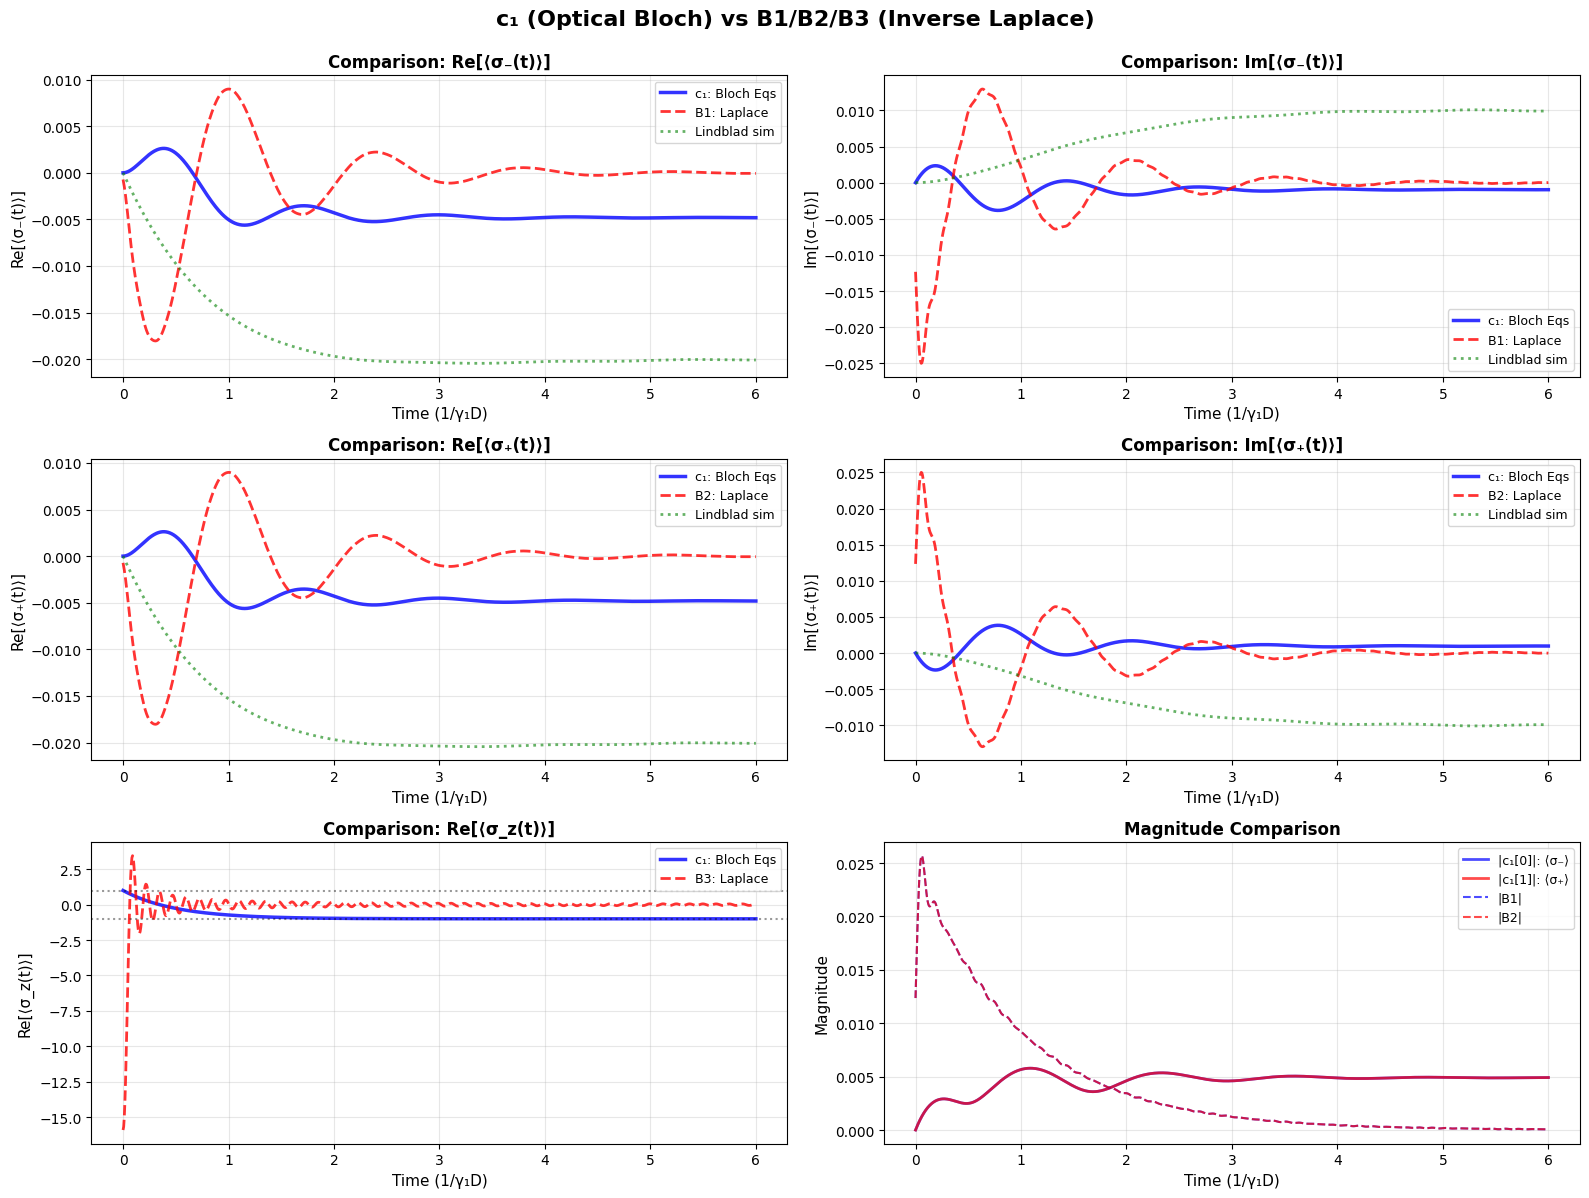

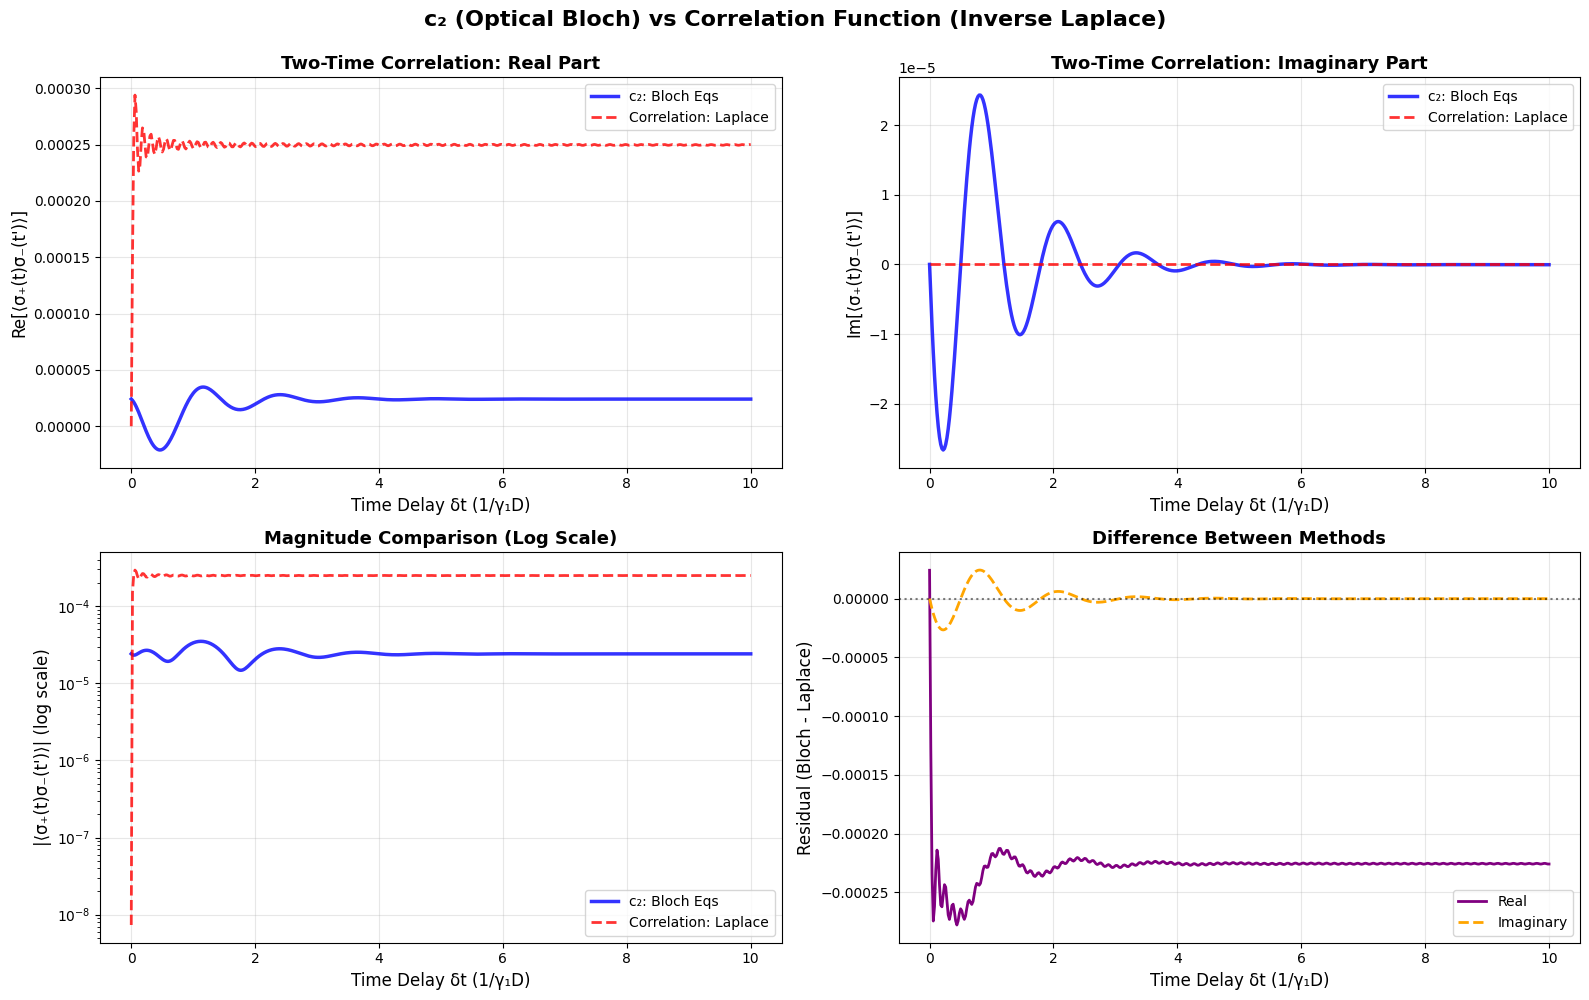


✓ Analysis complete!


In [31]:
# ========== Method 1: Lindblad Master Equation ==========
print("\n[1/4] Running Lindblad master equation simulation...")
psi0 = np.array([1, 0], dtype=complex)
rho0 = np.outer(psi0, psi0.conj())
rho0_vec = rho0.flatten()

solution = solve_ivp(
    lindblad_master_equation,
    t_span=(0, t_final),
    y0=rho0_vec,
    t_eval=times,
    method='DOP853',
)

# Extract observables
n_expect = np.zeros(len(solution.t))
sigma_dag_expect = np.zeros(len(solution.t), dtype=complex)
sigma_expect = np.zeros(len(solution.t), dtype=complex)

for i, t in enumerate(solution.t):
    rho = solution.y[:, i].reshape((2, 2))
    n_expect[i] = np.trace(rho @ n).real
    sigma_dag_expect[i] = np.trace(rho @ sigma_dag)
    sigma_expect[i] = np.trace(rho @ sigma)

print(f"  Steady-state ⟨n⟩ = {n_expect[-100:].mean():.6e}")

# ========== Method 2: Optical Bloch Equations ==========
print("\n[2/4] Solving optical Bloch equations (c₁ and c₂)...")

# Solve c₁
psi_ground = np.array([1, 0], dtype=complex)
c1_initial = get_initial_c1_from_state(psi_ground)
solution_c1 = solve_c1(c1_initial, times, gamma_1D, Omega, Omega_R)

print(f"  c₁ final ⟨σ₊⟩ = {solution_c1.y[1,-1]:.6e}")

# Solve c₂
c1_steady = solution_c1.y[:, -1]
sigma_plus_steady = c1_steady[1]
c2_initial = get_initial_c2_from_c1_steady_state(c1_steady)
solution_c2 = solve_c2(c2_initial, delay_times, gamma_1D, Omega, Omega_R, sigma_plus_steady)

print(f"  c₂ initial ⟨σ₊σ₋⟩ = {solution_c2.y[0,0]:.6e}")

# ========== Method 3: Inverse Laplace Transform ==========
print("\n[3/4] Computing inverse Laplace transforms...")
omega_range = np.linspace(-50, 50, 2000)

B1_time = inverse_laplace_transform(calculate_B1, times, omega_range,
                                    Omega_R, gamma_1D, D, Omega)
B2_time = inverse_laplace_transform(calculate_B2, times, omega_range,
                                    Omega_R, gamma_1D, D, Omega)
B3_time = inverse_laplace_transform(calculate_B3, times, omega_range,
                                    gamma_1D, D, Omega)
correlation_time = inverse_laplace_transform(calculate_correlation_function,
                                             delay_times, omega_range,
                                             Omega_R, gamma_1D, D, Omega)

print(f"  B2 final = {B2_time[-1]:.6e}")
print(f"  Correlation initial = {correlation_time[0]:.6e}")

# ========== Plotting ==========
print("\n[4/4] Creating comparison plots...")

fig1 = plot_c1_vs_laplace(solution_c1, times, B1_time, B2_time, B3_time,
                          sigma_expect, sigma_dag_expect)

fig2 = plot_c2_vs_correlation(solution_c2, delay_times, correlation_time)

plt.show()

print("\n" + "="*70)
print("✓ Analysis complete!")
print("="*70)